In [1]:
from lasso import *
from run_STORM import res2func, set_result as _set_result, get_result, merge_results, params2commands, HOME_DIR
from numpy import savez, load, linspace, exp, log, nanpercentile
from os import makedirs; makedirs('images', exist_ok=True); makedirs('videos', exist_ok=True)
from os.path import join
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore", message='Adding an axes using the same arguments as a previous axes')

LOAD = 'large_w'

%matplotlib notebook
from matplotlib.pyplot import *
mpl_figure = figure

rcParams['figure.figsize'] = [9.5, 6]
def figure(name, *args, **kwargs):
    close(name); f = mpl_figure(name, *args, **kwargs);return f

def type2str(T):
    if T is True:
        return 'adaptive'
    elif T is False:
        return 'fixed'
    else:
        return T

In [2]:
# I don't know why I need to run this a second time...
%matplotlib notebook
# %matplotlib qt

In [3]:
try:
    with load(join('data','lasso2_arrays.npz'), allow_pickle=True) as tmp:
        results = tmp['results'].item(0).copy()
except Exception:
    results = {}

set_result = lambda *args: _set_result(results, *args)
Result = lambda *args, **kwargs: get_result(results, *args, **kwargs)    

labels = ['continuous gap', 'discrete gap', 'E', 
          'E^* continuous', 'E^* discrete', 
          'pixel size', 'number of pixels',
          'continuous threshold', 'discrete threshold',
         ]
style = ['m-','m--','g-.','g-','g--','b--','b-','r-','r--',
        'k--','k-.','k:']

def best_fit(x,y,rate,shift=25):
    x = x**(-rate)
    scale = max(1e-8/x.min(), (y/x).max()/shift)
    return scale * x

def set_axes(ax, I):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(left=1, right=I)
    ax.set_ylim(bottom=1e-4, top=1e3)
    ax.grid(True, 'major', 'both')


# Initialise examples

In [4]:
from skimage.io import imread
in_file = join('data','sequence-as-stack-MT4.N2.HD-2D-Exp.tif')
data = imread(in_file).astype(FTYPE)/2000-0.07

# PSF=2.58 -> Norm=63.341061, PSF=2 -> Norm=63.593735
A = kernelMap2D(x=linspace(0,1,64+1)[:-1]+1/128, sigma=2/64/sqrt(2*log(2)), Norm=63.6)
pms = {'w':0.5, 'stop':1e-3, 'scale':1e3, 
       'in_file':in_file, 'max_index':data.shape[0]}
if LOAD == 'large_w':
    pms['w'] = 0.15

In [5]:
from matplotlib.pyplot import hist
figure('data histogram')
tmp = hist(array(data).reshape(-1), bins=300)
gca().set_xlim(-0.1,0.1)
# average noise is about 0

# Run small example

In [8]:
pms.update({
    'adaptive':(1e5,True), 'iters':(1000,1.4), 'chunks':8, 'directory':LOAD
})
try: # check if files already exist
    Recon, results = merge_results(pms['chunks'], LOAD)
except Exception:
    import subprocess
    import tempfile
    from time import sleep

    commands = params2commands(**pms)

    processes = []
    for c in commands:
        f = tempfile.TemporaryFile()
        p = subprocess.Popen(c.split(),stdout=f,cwd=HOME_DIR)
        processes.append((p, f))

    with tqdm(total=pms['max_index'],smoothing=0.) as pbar:
        while any(p.poll()==None for p,f in processes):
            count = 0
            for p,f in processes:
                f.seek(0)
                count += len(f.readlines())
            pbar.update(count-pbar.n)
            sleep(1)
        pbar.update(pms['max_index']-pbar.n)

    for p, f in processes:
        f.close()

    Recon, results = merge_results(pms['chunks'], LOAD)


In [9]:
I = next(iter(results.values()))[-2]
record = empty((len(results),)+next(iter(results.values()))[-1].shape,dtype='float64')
for k,v in results.items():
    record[k[-1]] = v[-1]
record = record.transpose((1,2,0))
summary = nanpercentile(record,(25,50,75), axis=-1)

<IPython.core.display.Javascript object>


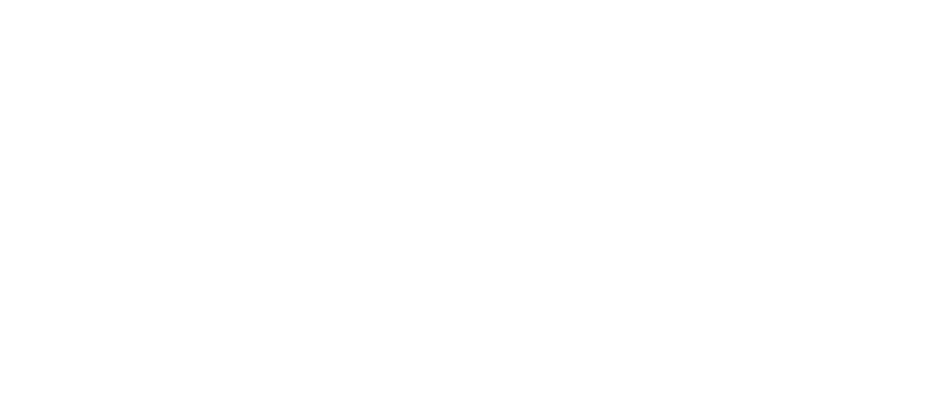

In [10]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = figure('Convergence plot', figsize=(9.5,4))
ax = fig.subplots(ncols=3,sharex='all',subplot_kw={'xscale':'log','yscale':'log'})
def interval_plot(a,values,c,s,label):
    a.plot(I,values[1],color=c,linestyle=s,label=label)
    a.fill_between(I,values[0],values[2],color=c, alpha=.2)
interval_plot(ax[0],summary[:,0],style[0][0],style[0][1:],'continuous gap')
interval_plot(ax[0],summary[:,1],style[1][0],style[1][1:],'discrete gap')
interval_plot(ax[0],summary[:,7],style[7][0],style[7][1:],'continuous threshold')
interval_plot(ax[0],summary[:,8],style[8][0],style[8][1:],'discrete threshold')
ax[0].set_title('Function convergence')

interval_plot(ax[1],summary[:,5],style[5][0],style[5][1:],'pixel width')
ax[1].set_title('Min. pixel width')
interval_plot(ax[2],summary[:,6],style[6][0],style[6][1:],'number of pixels')
ax[2].set_title('Number of pixels')

ax[0].plot(I, .01/I**.666666666,'k-')
ax[1].plot(I, .03/I**.666666666,'k-')
ax[2].plot([100],'k-',label='n^{-2/3}')
for a in ax:
    a.set_xlabel('iterations')
ax[0].set_xlim(1,pms['iters'][0])
fig.legend(loc='lower center', ncol=4)
tight_layout()
fig.subplots_adjust(bottom=0.3) 
savefig(join('images','lasso2_convergence.png'), dpi=300)

<IPython.core.display.Javascript object>


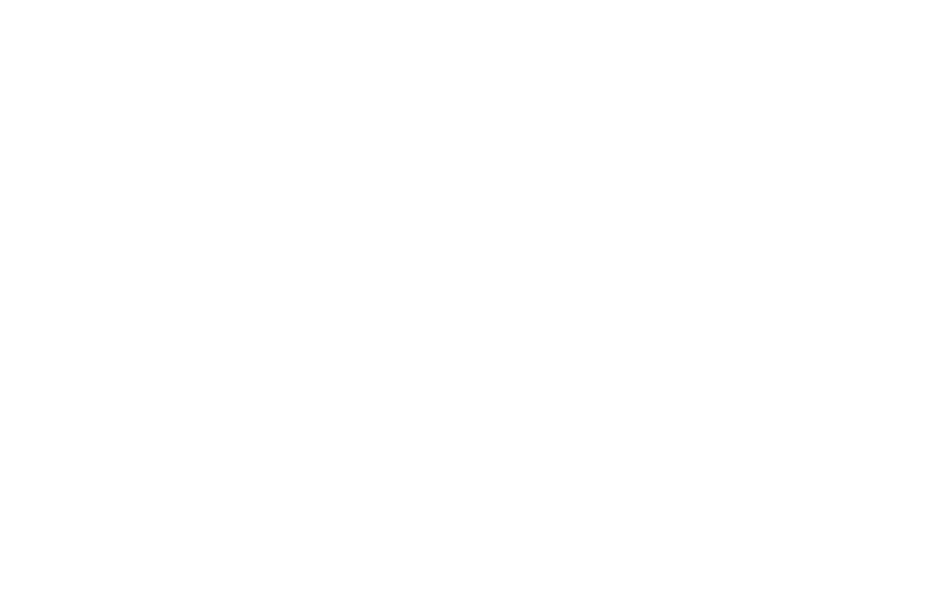

In [11]:
from numpy import log10, concatenate
figure('pixel size distribution (log_10)')
hist((Recon.dof_map[:,-1]), bins=100, density=False)


In [12]:
padstr = lambda x: x + ' '*(35-len(x))
print(padstr('Total pixels: '), Recon.size)
print(padstr('Average pixels: '), int(Recon.size/data.shape[0]))
print(padstr('Average h: '), round(Recon.FS.H.mean(),7), round(Recon.FS.H.mean()*6.4,7))
print(padstr('Number of pixels for average h: '), int(1/Recon.FS.H.mean()**2))
print(padstr('Probably saving: '), int(1e-5/Recon.FS.H.mean()**2))
data.shape[0]/(Recon.size*Recon.FS.H.mean()**2)

Total pixels:                       221636
Average pixels:                     73
Average h:                          0.0040965 0.0262173
Number of pixels for average h:     59591
Probably saving:                    0


811.9892633526134

<IPython.core.display.Javascript object>


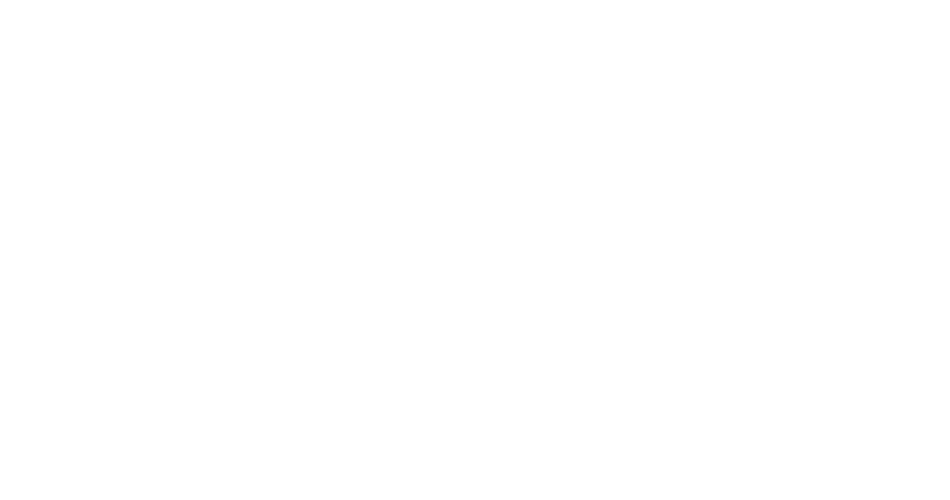

In [13]:
disc = Recon.discretise(11)

d = data.mean(0)
figure('reconstruction', figsize=(9.5,5))
subplot(121)
imshow(disc, origin='upper', extent=[0,1,0,1])
subplot(122)
imshow(d, origin='upper', extent=[0,1,0,1])
tight_layout()

<IPython.core.display.Javascript object>


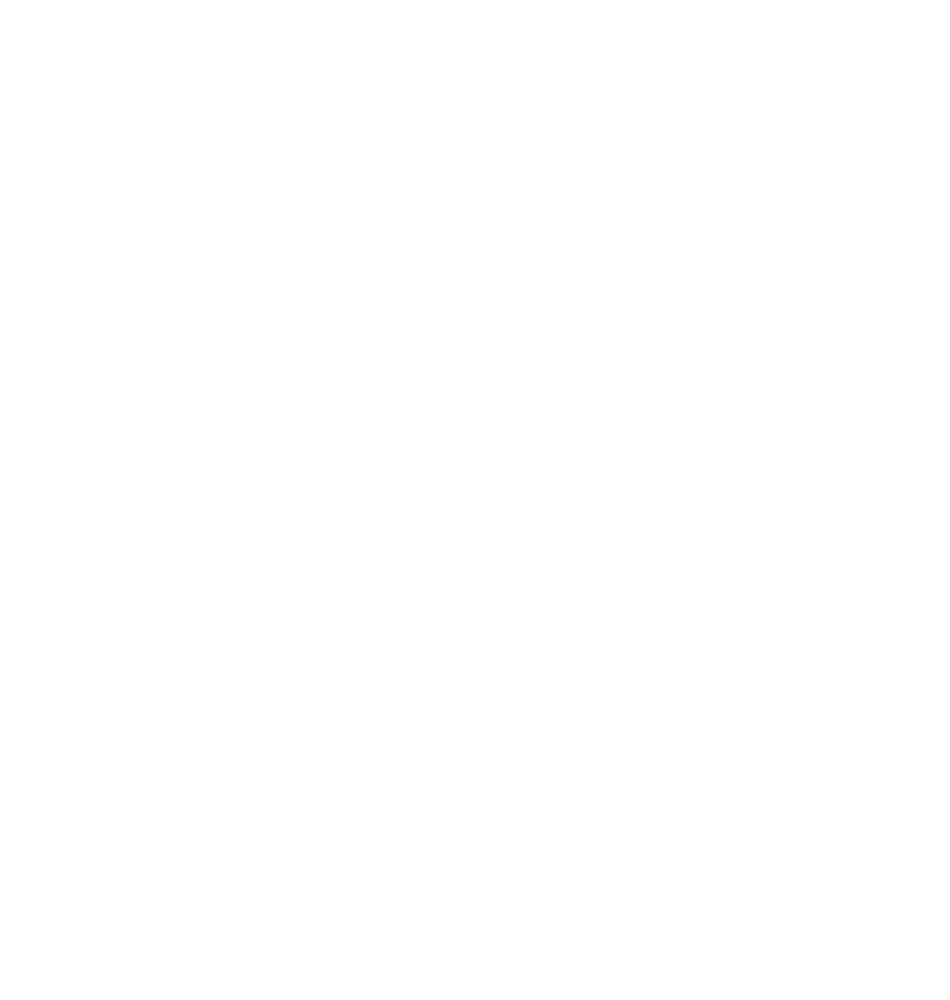

In [14]:
d = imread(join('data','STORM_comp_raw.png')).astype(FTYPE)
figure('nice reconstruction', figsize=(9.5,10))
subplot(221)
imshow(log(disc+1e+2), origin='upper', extent=[0,6.4,0,6.4])
subplot(222)
imshow(log(d+10**+2), origin='upper', extent=[0,6.4,0,6.4])
subplot(212)
imshow(log(data.mean(0)-data.mean()+1), origin='upper', extent=[0,6.4,0,6.4])
tight_layout()
savefig(join('images','STORM_recon.png'), dpi=300)
savefig(join('images','STORM_recon_%s.png'%LOAD), dpi=800)

<IPython.core.display.Javascript object>


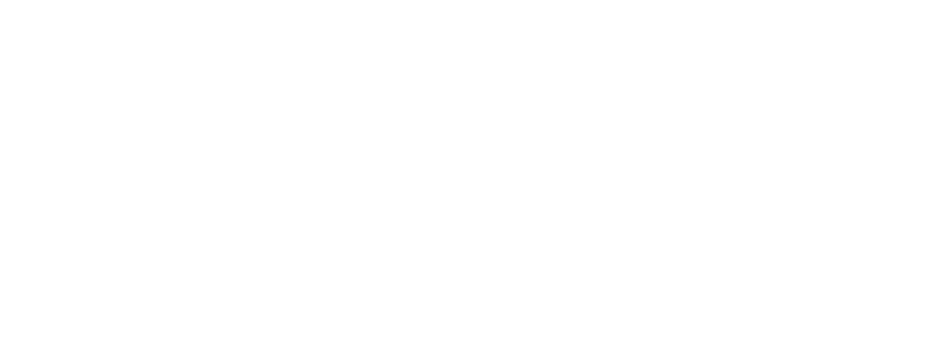

In [15]:
figure('data', figsize=(9.5,3.5))
ax = subplot(131); ax.imshow(data[1], extent=[0,6.4,0,6.4]); #ax.set_title('Data image 1')
ax = subplot(132); ax.imshow(data[10], extent=[0,6.4,0,6.4]); #ax.set_title('Data image 10')
ax = subplot(133); ax.imshow(data[100], extent=[0,6.4,0,6.4]); #ax.set_title('Data image 10')
tight_layout()
savefig(join('images','STORM_data.png'), dpi=300)